In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [11]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
gene = "RPS24"

In [3]:
outpath = "/scratch/PI/horence/JuliaO/single_cell/DiffSplice/notebooks/output/lemur_RPS24_scatter/"

In [4]:
# def compartment_colors(compartments):

#     import matplotlib.colors as pltcolors

#     cmap = plt.cm.get_cmap("YlOrRd")

#     compartment_color_dict = {}
#     j=1/len(compartments)
#     for c in compartments:
#         compartment_color_dict[c] = pltcolors.to_hex(cmap(j))
#         j+=1/len(compartments)

#     return compartment_color_dict
  
# create a color dictionary for donors (our colors)
def compartment_colors(compartments):
    compartment_color_dict = {comp : col for comp, col in zip(compartments,sns.color_palette("deep",len(compartments)))}

    # ensure same colors for key compartments
    palette = sns.color_palette("deep",4)
    compartment_color_dict["Endothelial"] = palette[0]
    compartment_color_dict["endothelial"] = palette[0]
    compartment_color_dict["Epithelial"] = palette[1]
    compartment_color_dict["epithelial"] = palette[1]
    compartment_color_dict["Immune"] = palette[2]
    compartment_color_dict["immune"] = palette[2]
    compartment_color_dict["Stromal"] = palette[3]
    compartment_color_dict["stromal"] = palette[3]
    return compartment_color_dict

In [5]:
def load_gtf(gtf_file,filt_chr):
  gtf = pd.read_csv(gtf_file, names = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"], sep="\t")
  if 'NC_000023.11' in gtf["seqname"].unique():
    can_chrom = [x for x in gtf["seqname"].unique() if x.startswith("NC_")]
    name_dict = {x : "chr" + str(int(x.split("_")[1].split(".")[0])) for x in can_chrom}
    name_dict['NC_000023.11'] = "chrX"
    name_dict['NC_000024.10'] = "chrY"
    name_dict['NC_012920.1'] = "chrM"
    gtf["seqname"] = gtf["seqname"].map(name_dict)
    gtf = gtf[~gtf["seqname"].isna()]
    filt_chr = False
  #   gtf = gtf[gtf["feature"] == "exon"]
  try:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_name").str[1].str.split(";").str[0].str.split('"').str[1]
  except:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_id").str[1].str.split(";").str[0].str.split('"').str[1]
  gtf["transcript_id"] = gtf["attribute"].str.split("transcript_id").str[1].str.split(";").str[0].str.split('"').str[1]
#  filt_chr = True
  if filt_chr:
    # don't include immature scaffolds
    chromosomes = gtf["seqname"].unique()
    chromosomes = [x for x in chromosomes if "_" not in x and not x.startswith("KN")]
#    print("chromosomes",chromosomes)
    gtf = gtf[gtf["seqname"].isin(chromosomes)]
  gtf["chr_gene"] = gtf["seqname"] + gtf["gene_id"]
  return gtf

In [6]:
# datanames = ["TS_10x_redo","TSP2_10x_rerun_3prime_RPS24"]
# datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
# datanames = ["TSP1_10x_with_postprocessing_nopanc_cellann","TSP2_10x_rerun_with_postprocessing_3prime_cellann"]
# datanames = ["Lemur_Antoine_10X_with_postprocessing"]
datanames = ["Lemur_10x_Antoine_with_postprocessing_cellann","Lemur_10x_Stumpy_with_postprocessing_cellann"]
# datanames = ["Tabula_muris_senis_P1_10x_with_postprocessing","Tabula_muris_senis_P2_10x_with_postprocessing"]
gene = "RPS24"
# datanames = ["HLCA4_P2","HLCA4_P3"]
dfs = []
cell_lim = 20
hc_lim = 10
suffixes = ["all","hc"]

#human
# juncs = ["chr10:RPS24:78037304:+|chr10:RPS24:78040204:+","chr10:RPS24:78037304:+|chr10:RPS24:78040615:+","chr10:RPS24:78037441:+|chr10:RPS24:78040204:+","chr10:RPS24:78037441:+|chr10:RPS24:78040615:+","chr10:RPS24:78037982:+|chr10:RPS24:78040204:+","chr10:RPS24:78037304:+|chr10:RPS24:78037439:+","chr10:RPS24:78037304:+|chr10:RPS24:78037965:+","chr10:RPS24:78037441:+|chr10:RPS24:78037965:+"]

#mouse
# juncs = ["chr14:Rps24:24493493:+|chr14:Rps24:24495430:+","chr14:Rps24:24493493:+|chr14:Rps24:24495775:+","chr14:Rps24:24493619:+|chr14:Rps24:24495430:+","chr14:Rps24:24493619:+|chr14:Rps24:24495775:+","chr14:Rps24:24494069:+|chr14:Rps24:24495430:+","chr14:Rps24:24493493:+|chr14:Rps24:24493617:+","chr14:Rps24:24493493:+|chr14:Rps24:24494052:+","chr14:Rps24:24493619:+|chr14:Rps24:24494052:+"]

#lemur
juncs = ["NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6267905:-","NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6267049:-","NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6267905:-","NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6267049:-","NC_033674.1:RPS24:6269942:-|NC_033674.1:RPS24:6267905:-","NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6270485:-","NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6269959:-","NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6269959:-"]

for dataname in tqdm(datanames):
  df = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/SZS_pipeline2/data/{}.pq".format(dataname),columns=["geneR1A_uniq","juncPosR1A","juncPosR1B","numReads","cell","tissue","compartment","free_annotation","refName_newR1","called"])
#   try:
#     df = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/Process_Mouse_Lemur/scripts/output/Process_CI_10x/{}.pq".format(dataname),columns=["geneR1A_uniq","juncPosR1A","juncPosR1B","numReads","cell","tissue","compartment","free_annotation","refName_newR1","called"])
#   except:
#     df = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/Process_Mouse_Lemur/scripts/output/Process_GLM_output/{}.pq".format(dataname),columns=["geneR1A_uniq","juncPosR1A","juncPosR1B","numReads","cell","tissue","compartment","free_annotation","refName_newR1", "inc_emp.p"])
#   df = df[df["called"] == 1]
  # make compartment labels the same for lemur
  df["compartment"] = df["compartment"].replace("lymphoid","Immune")
  df["compartment"] = df["compartment"].replace("myeloid","Immune")
  df["compartment"] = df["compartment"].replace("megakaryocyte-erythroid","Immune")
  df["compartment"] = df["compartment"].replace("stromal","Stromal")
  df["compartment"] = df["compartment"].replace("epithelial","Epithelial")
  df["compartment"] = df["compartment"].replace("endothelial","Endothelial")
  df["compartment"] = df["compartment"].replace("immune","Immune")


  df = df[df["geneR1A_uniq"] == gene]
  for junc in juncs:
    df["refName_newR1"].replace(junc + "|lin",junc,inplace=True)
  
  df = df[df["refName_newR1"].isin(juncs)]
  df["num_reads_cell"] = df["cell"].map(df.groupby("cell")["numReads"].sum())
  display(df["refName_newR1"].value_counts())
  df["ontology"] = df["tissue"] + df["compartment"] + df["free_annotation"]
  df["num_cell_ont"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
  df = df[df["num_cell_ont"] > cell_lim]
  temps = []
  for suff in suffixes:
    if suff == "all":
      temp = df
    elif suff == "hc":
      temp = df[df["num_reads_cell"] > hc_lim]
  
    
    for junc, junc_df in temp.groupby("refName_newR1"):
      temp["{}_count".format(junc)] = temp["cell"].map(defaultdict(int,pd.Series(junc_df.numReads.values,index=junc_df.cell).to_dict()))
#     temp["junc_count"] = temp[[x for x in temp.columns if "_count" in x]].sum(axis=1)
    for junc in juncs:
      if "{}_count".format(junc) not in temp.columns:
        temp["{}_count".format(junc)] = 0
    temp["junc_count"] = temp[[x + "_count" for x in juncs]].sum(axis=1)
    for junc in juncs:
      temp["{}_frac".format(junc)] = temp["{}_count".format(junc)]/temp["junc_count"]

    


    quantiles = [0.25, 0.5, 0.75]
    for junc in juncs:
      for q in quantiles:
        temp[junc + "_med_frac_" + str(q) + "_" + suff] = temp["ontology"].map(temp.groupby("ontology")[junc + "_frac"].quantile(q))
    temps.append(temp)
    
  df = temps[0]
  for c in [x for x in temps[1].columns if "hc" in x]:
    df.loc[temps[1].index,c] = temps[1][c]
    
  df = df.drop_duplicates("ontology")
  dfs.append(df)

  0%|          | 0/2 [00:00<?, ?it/s]

NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6267049:-    53895
NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6267905:-    36964
NC_033674.1:RPS24:6269942:-|NC_033674.1:RPS24:6267905:-     1275
NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6270485:-      673
NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6269959:-      591
NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6269959:-      439
NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6267905:-      246
Name: refName_newR1, dtype: int64

/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
 50%|█████     | 1/2 [03:23<03:23, 203.12s/it]

NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6267049:-    59764
NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6267905:-    15602
NC_033674.1:RPS24:6269942:-|NC_033674.1:RPS24:6267905:-     1218
NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6269959:-      920
NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6267905:-      360
NC_033674.1:RPS24:6270609:-|NC_033674.1:RPS24:6270485:-      303
NC_033674.1:RPS24:6270483:-|NC_033674.1:RPS24:6269959:-      180
Name: refName_newR1, dtype: int64

100%|██████████| 2/2 [05:56<00:00, 178.21s/it]


In [8]:
for i in range(len(datanames)):
  dfs[i].rename(columns={x : x + "_" + datanames[i] for x in dfs[1].columns if "med_frac" in x},inplace=True)
merge_df = dfs[0].merge(dfs[1],on="ontology",how="outer",suffixes=("","_x"))
for cx in [x for x in merge_df.columns if x.endswith("_x")]:
  c = cx[:-2]
  merge_df.loc[merge_df[c].isna(),c] = merge_df.loc[merge_df[c].isna(),cx]
merge_df.drop([x for x in merge_df.columns if x.endswith("_x")],inplace=True,axis=1)

/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
ontologies = dfs[0]["free_annotation"].unique()

saved at /scratch/PI/horence/JuliaO/single_cell/DiffSplice/notebooks/output/lemur_RPS24_scatter/Lemur_10x_Antoine_with_postprocessing_cellann_RPS24_scatter_.25_lemur.png


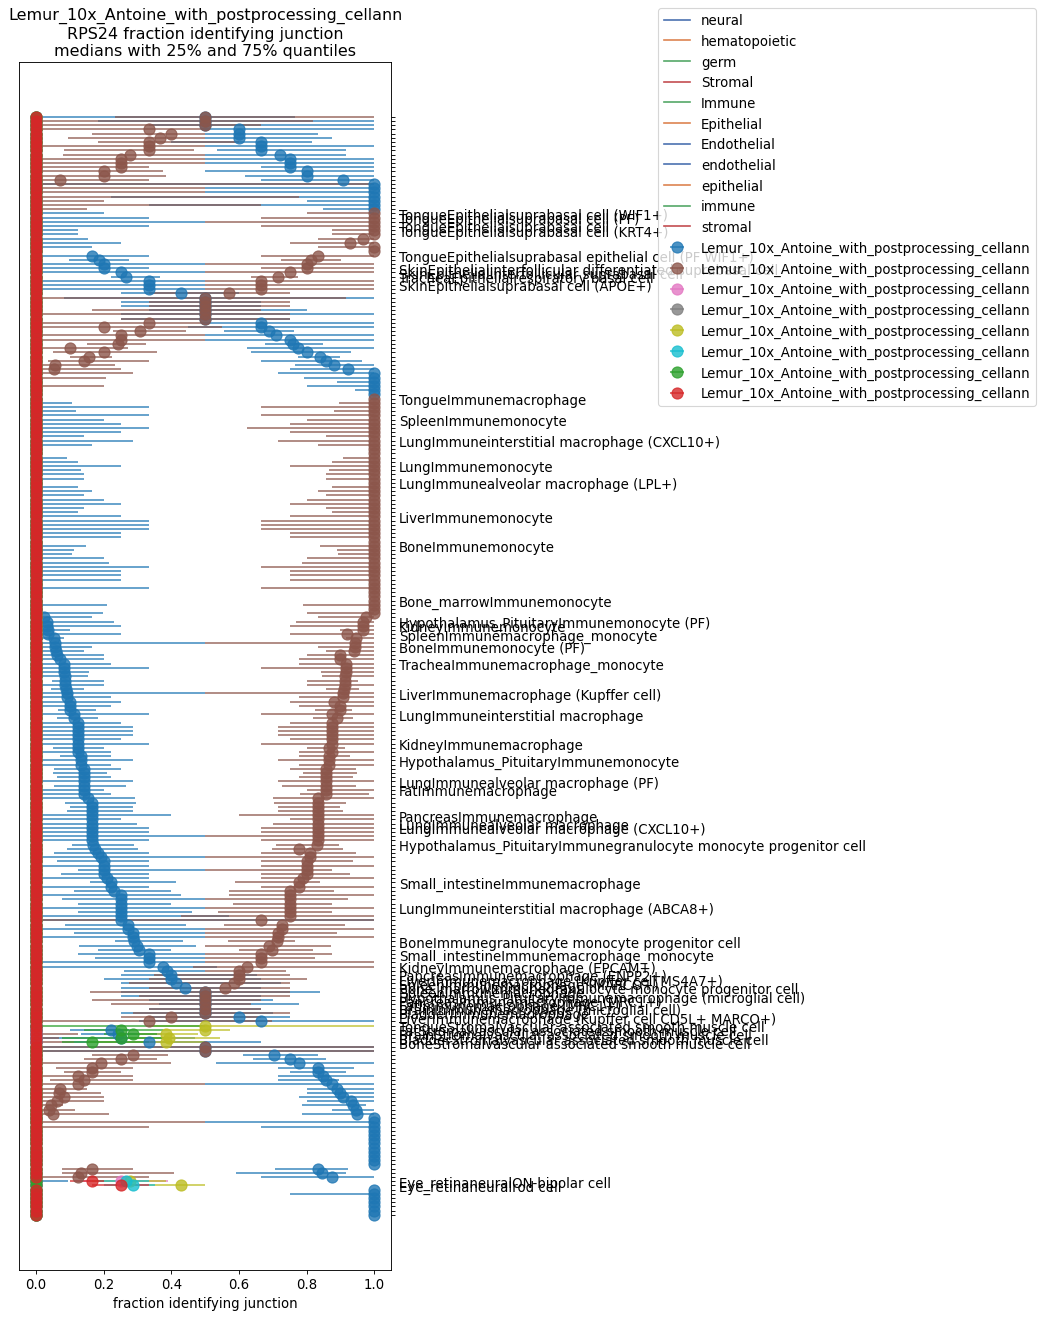

In [12]:
ind = 0
temp = dfs[ind]
rare = ["Proximal Ciliated","Proximal Basal","Proliferating Basal","Mucous","Serous",
        "Capillary Intermediate 2","Bronchial Vessel 1","Bronchial Vessel 2","Lipofibroblast",
        "Mesothelial","CD8+ Memory/Effector T","CD4+ Memory/Effector T","Neutrophil","Mast Cell/Basophil Type 2",
       "Platelet/Megakaryocyte","Macrophage","Proliferating Macrophage","Myeloid Dendritic Type 1","EREG+ Dendritic",
       "TREM2+ Dendritic","Classical Monocyte","OLR1+ Classical Monocyte"]
# temp = temp.sort_values(["m_inc_TS_10x_redo","m_inc_TSP2_10x_rerun_3prime_MYL6"])
# temp["avg"] = temp[['chr10:RPS24:78037304:+|chr10:RPS24:78040204:+_med_frac_0.5_all_{}'.format(datanames[ind]),'chr10:RPS24:78037304:+|chr10:RPS24:78040204:+_med_frac_0.5_all_' + datanames[ind]]].mean(axis=1)
temp["avg"] = temp[["{}_med_frac_0.5_all_{}".format(x,datanames[ind]) for x in juncs[:2]]].mean(axis=1)
# temp["avg"] 
# sub_types = list(temp[temp["compartment"] == "Endothelial"]["ontology"]) + list(temp[temp["compartment"] == "Epithelial"]["ontology"])[:10]+ list(temp[temp["compartment"] == "Stromal"]["ontology"])[-10:]+ list(temp[temp["compartment"] == "Immune"]["ontology"])[::6]
# temp = temp.sort_values("avg")
sub_types = []
temp = temp.sort_values(by=["compartment","{}_med_frac_0.5_all_{}".format(juncs[0],datanames[ind])],ascending=False)
if sub_types != []:
  temp = temp[temp["ontology"].isin(sub_types)]
datanames = datanames[:2]
# comp_dict = {"endothelial" : "blue", "epithelial" : "black", "stromal" : "green", "immune" : "red"}
# compartments = sorted([x for x in list(df["compartment"].unique()) if x != None])

comp_dict = compartment_colors(temp["compartment"].unique()) 
matplotlib.rcParams.update({'font.size': 12})

# for tiss, temp in temp.groupby("tissue"):
plt.figure(num=None, figsize=(6, 20), dpi=80, facecolor='w', edgecolor='k')
comp_colors = [comp_dict[x] for x in temp["compartment"]]
x_vals = range(temp.shape[0])
# colors = [u'#1f77b4', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
colors = [u'#1f77b4', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf', u'#2ca02c', u'#d62728']
#   colors = [u'#9467bd', u'#2ca02c', u'#d62728', u'#ff7f0e', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

fillstyles = ["full","full","full"]
fill_dict = {x : y for x, y in zip(datanames,fillstyles)}
markers = ["o","P","o"]
marker_dict = {x : y for x, y in zip(datanames,markers)}
# for i in range(len(juncs)):
#   junc = juncs[i]
for i in range(len(juncs)):
  junc = juncs[i]
  dn = datanames[ind]
#     for dn in datanames:

#   plt.errorbar(x_vals,temp["m_inc_" + dn],yerr=[temp["m_inc_" + dn] - temp["m_inc_0.25_" + dn],temp["m_inc_0.75_" + dn] - temp["m_inc_" + dn]],linestyle="",marker=marker_dict[dn],label=dn,alpha = 0.6,fillstyle=fill_dict[dn])
  plt.errorbar(temp["{}_med_frac_0.5_all_{}".format(junc,dn)],x_vals,xerr=[temp["{}_med_frac_0.5_all_{}".format(junc,dn)] - temp["{}_med_frac_0.25_all_{}".format(junc,dn)],temp["{}_med_frac_0.75_all_{}".format(junc,dn)] - temp["{}_med_frac_0.5_all_{}".format(junc,dn)]],linestyle="",marker="o",markersize=10,label=dn ,alpha =0.8,fillstyle=fill_dict[dn],color=colors[i])
#     plt.errorbar(temp["{}_med_frac_0.5_hc_{}".format(junc,dn)],x_vals,xerr=[temp["{}_med_frac_0.5_hc_{}".format(junc,dn)] - temp["{}_med_frac_0.25_hc_{}".format(junc,dn)],temp["{}_med_frac_0.75_hc_{}".format(junc,dn)] - temp["{}_med_frac_0.5_hc_{}".format(junc,dn)]],linestyle="",marker=marker_dict[dn],label=dn ,alpha = 0.6,fillstyle=fill_dict[dn],color=colors[i])

for comp, col in comp_dict.items():
  plt.plot([-1],[1],label=comp,color=col)
#     plt.errorbar(x_vals,temp[junc + "_med_frac_0.5_" + dn].replace(0,np.nan),yerr=[temp[junc + "_med_frac_0.5_" + dn] - temp[junc + "_med_frac_0.25_" + dn],temp[junc + "_med_frac_0.75_" + dn] - temp[junc + "_med_frac_0.5_" + dn]],linestyle="",marker=marker_dict[dn],label=junc,alpha = 0.6,color=colors[i],fillstyle=fill_dict[dn])
plt.legend(bbox_to_anchor=(1.7, 1.05))
#   temp.loc[temp["free_annotation"].isin(rare),"free_annotation"] += " ^^^"


ontologies =list(temp["ontology"])
new_ontologies = []
for i in range(len(ontologies)):
  if (("suprabasal" not in ontologies[i]) & ("resp" not in ontologies[i]) & ("lymphocyte" not in ontologies[i]) & ("macrophage" not in ontologies[i]) & ("retina" not in ontologies[i])& ("monocyte" not in ontologies[i])& ("mast" not in ontologies[i]) & ("fast" not in ontologies[i]) & ("slow" not in ontologies[i]) & ("smooth" not in ontologies[i])):
    new_ontologies.append("")
  else:
    new_ontologies.append(ontologies[i])
    
# plt.yticks(x_vals,temp["ontology"])#,rotation=90)
plt.yticks(x_vals,new_ontologies)#,rotation=90)
plt.xlim([-0.05,1.05])
count = 0

color_labels = False
if color_labels:
  for tick_label in plt.gca().get_yticklabels():
    tick_label.set_color(comp_colors[count])
    count += 1 
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.xlabel("fraction identifying junction")
plt.title("{}\n{} fraction identifying junction\nmedians with 25% and 75% quantiles".format(datanames[ind],gene))
plt.savefig("{}{}_{}_scatter_.25_lemur.png".format(outpath,datanames[ind],gene),bbox_inches="tight")
plt.savefig("{}{}_{}_scatter_.25_lemur.pdf".format(outpath,datanames[ind],gene),bbox_inches="tight",transparent=True)

print("saved at","{}{}_{}_scatter_.25_lemur.png".format(outpath,datanames[ind],gene))
plt.show()